# Medición de tiempo con Python

La idea de estos apuntes es presentar medidas de tiempo para varias implementaciones de un mismo algoritmo desde Python y ver como la implementación afecta al rendimiento de este. Para esto se implementará una función que calcule la suma de números enteros.

## Módulo timeit

Se empleará para medir el tiempo. La forma de uso es mucho más complicada que lo que se muestra en los ejemplos, pero se emplea la forma simplificada por fines demostrativos. La función timeit devuelve el tiempo transcurrido luego de ejecutar la función indicada la cantidad de veces en su segundo argumento. Por esta razón, para obtener el tiempo promedio transcurrido se dividirá el resultado de `timeit` entre la cantidad de veces.

In [1]:
import timeit

## Implementación while

In [2]:
def sumar_enteros_while(n=1_000_000):
    i = 0
    s = 0
    while (i < n):
        s += i
        i += 1
    return s

In [3]:
timeit.timeit(sumar_enteros_while,number=1)

0.08768370199686615

In [4]:
timeit.timeit(sumar_enteros_while,number=10)/10

0.07132216570025776

In [5]:
timeit.timeit(sumar_enteros_while,number=100)/100

0.06873736442998052

## Implementación for

In [6]:
def sumar_enteros_for(n=1_000_000):
    s = 0
    for i in range(n):
        s += i
    return s

In [7]:
timeit.timeit(sumar_enteros_for,number=1)

0.04462809099641163

In [8]:
timeit.timeit(sumar_enteros_for,number=10)/10

0.04690194689974305

In [9]:
timeit.timeit(sumar_enteros_for,number=100)/100

0.044744732510007455

Se puede observar que la función que emplea el bucle `for` es ligeramente más rápida que la función implementada con bucle `while`. Esto se debe a que la implementación con bucle `for` está más optimizada a nivel de ensamblador. Como ejemplo, se va a mostrar como afecta al rendimiento la aparición de operaciones "triviales", no interesa si son colocadas por desconocimiento o por distracción.

In [10]:
def sumar_enteros_for_incremento(n=1_000_000):
    s = 0
    c = 0
    for i in range(n):
        s += c
        c += 1
    return s

In [11]:
timeit.timeit(sumar_enteros_for_incremento,number=1)

0.06778984000266064

In [12]:
timeit.timeit(sumar_enteros_for_incremento,number=10)/10

0.06312882939964766

In [13]:
timeit.timeit(sumar_enteros_for_incremento,number=100)/100

0.06508082216998445

Bastó con incluir una operación de incremento para que el tiempo sea relativamente similar a la implementación con bucle `while`. 

In [14]:
def sumar_enteros_for_incremento_comp(n=1_000_000):
    s = 0
    c = 0
    for i in range(n):
        if i < n: 
            pass
        s += c
        c += 1
    return s

In [15]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=1)

0.08715564100566553

In [16]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=10)/10

0.08119392570006312

In [17]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=100)/100

0.08394749498998863

Al añadir la operación de comparación la función ahora es incluso más lenta. Se debe tener en cuenta estos detalles para implementar funciones. Un camino alternativo, es emplear las funciones internas que proporciona el lenguaje.

## Con funciones internas

In [18]:
def sumar_enteros_idiomatic(n=1_000_000):
    return sum(range(n))

In [19]:
timeit.timeit(sumar_enteros_idiomatic,number=1)

0.011946686005103402

In [20]:
timeit.timeit(sumar_enteros_idiomatic,number=10)/10

0.012895151499833446

In [21]:
timeit.timeit(sumar_enteros_idiomatic,number=100)/100

0.013174740149988793

Se observa que las funciones internas de Python ya están muy optimizadas y lo recomendable es emplearlas si están disponibles.

## Consideraciones sobre las mediciones del tiempo

Como se mencionó el módulo timeit proporciona el tiempo acumulado una determinada cantidad de veces indicada en su segundo argumento. A continuación mediante el uso de gráficas se presentará más a detalle lo que ocurre con estas mediciones.

In [22]:
import matplotlib.pyplot as plt

In [23]:
timeits = []
t = 0
for i in range(100):
    t = timeit.timeit(sumar_enteros_while,number=1)
    timeits.append(t)

In [24]:
x = list(range(len(timeits)))

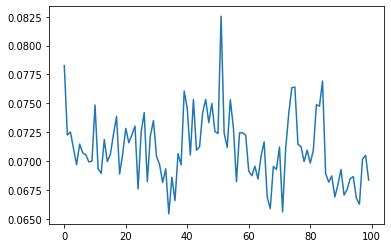

In [25]:
plt.plot(x,timeits)

Como se observa, las mediciones son irregulares y parecen tener picos. Esto puede ser debido a que el medidor de tiempo empleado es sensible al ruido. Por esto se empleará otro medidor de tiempo para ver que ocurre.

In [26]:
import time

In [27]:
times = []
tic = 0
toc = 0
e = 0
for i in range(100):
    tic = time.time()
    sumar_enteros_while()
    toc = time.time()
    e = toc - tic
    times.append(e)

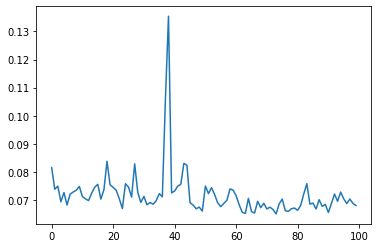

In [28]:
plt.plot(x,times)

Un gráfico conjunto de las dos formas de medir el tiempo

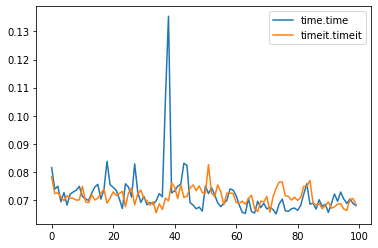

In [29]:
# gráfico con leyenda
plt.plot(x,times, label='time.time')
plt.plot(x,timeits, label='timeit.timeit')
# para mostrar la leyenda
plt.legend()

Se observa que ambas mediciones de tiempo son muy irregulares. Sumar el ruido que se ha introducido en nuestras mediciones y luego promediar implicaría que estamos promediando el ruido y esto desviaría el resultado final de lo real. ¿Cómo medir esta distorsión? ¿Cómo eliminar el ruido?

## Filtro mediana unidimensional

El filtro de mediana es un algoritmo empleado para eliminar ruido.

In [30]:
import statistics

In [31]:
timeitsn = []
ventana = 9
for i in range(len(timeits)):
    inicio = i - ventana if (i - ventana > 0) else i
    fin = i + ventana if (i + ventana < len(timeits)) else len(timeits)
    timeitsn.append(statistics.median(times[inicio:fin]))

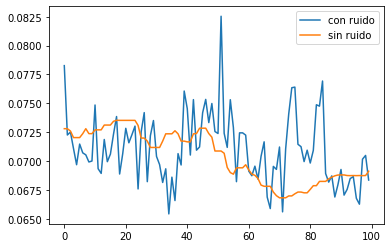

In [32]:
# gráfico con leyenda
plt.plot(x,timeits, label='con ruido')
plt.plot(x,timeitsn, label='sin ruido')
# para mostrar la leyenda
plt.legend()

Como puede observar en la gráfica, una vez aplicado el filtro a las mediciones, la tendencia es más regular.

## Comparación de las funciones implementadas

Se definen funciones con lo aprendido para poder usarlo de forma modular

In [33]:
def medir_timeit(f,veces):
    timeits = []
    t = 0
    for i in range(veces):
        t = timeit.timeit(f,number=1)
        timeits.append(t)
    return timeits

In [34]:
def medir_time(f,veces):
    times = []
    tic = 0
    toc = 0
    e = 0
    for i in range(veces):
        tic = time.time()
        f()
        toc = time.time()
        e = toc - tic
        times.append(e)
    return times

In [35]:
def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    for i in range(tam):
        inicio = i - ventana if (i - ventana > 0) else i
        fin = i + ventana if (i + ventana < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

Mediciones con timeit

In [36]:
t1 = medir_timeit(sumar_enteros_while,100)

In [37]:
t2 = medir_timeit(sumar_enteros_for,100)

In [38]:
t3 = medir_timeit(sumar_enteros_for_incremento,100)

In [39]:
t4 = medir_timeit(sumar_enteros_for_incremento_comp,100)

In [40]:
t5 = medir_timeit(sumar_enteros_idiomatic,100)

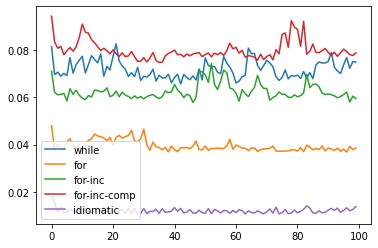

In [41]:
x = range(len(t1))
plt.plot(x,t1, label='while')
plt.plot(x,t2, label='for')
plt.plot(x,t3, label='for-inc')
plt.plot(x,t4, label='for-inc-comp')
plt.plot(x,t5, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [42]:
t1c = filtro_mediana(t1, 7)

In [43]:
t2c = filtro_mediana(t2, 7)

In [44]:
t3c = filtro_mediana(t3, 7)

In [45]:
t4c = filtro_mediana(t4, 7)

In [46]:
t5c = filtro_mediana(t5, 7)

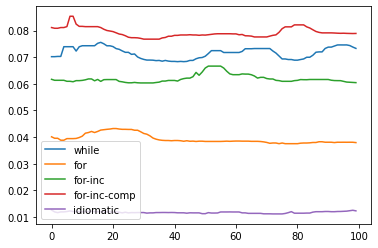

In [47]:
plt.plot(x,t1c, label='while')
plt.plot(x,t2c, label='for')
plt.plot(x,t3c, label='for-inc')
plt.plot(x,t4c, label='for-inc-comp')
plt.plot(x,t5c, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Mediciones con time

In [48]:
r1 = medir_time(sumar_enteros_while,100)

In [49]:
r2 = medir_time(sumar_enteros_for,100)

In [50]:
r3 = medir_time(sumar_enteros_for_incremento,100)

In [51]:
r4 = medir_time(sumar_enteros_for_incremento_comp,100)

In [52]:
r5 = medir_time(sumar_enteros_idiomatic,100)

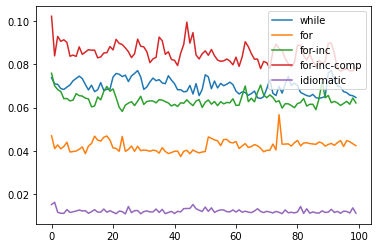

In [53]:
plt.plot(x,r1, label='while')
plt.plot(x,r2, label='for')
plt.plot(x,r3, label='for-inc')
plt.plot(x,r4, label='for-inc-comp')
plt.plot(x,r5, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [54]:
r1c = filtro_mediana(r1, 7)

In [55]:
r2c = filtro_mediana(r2, 7)

In [56]:
r3c = filtro_mediana(r3, 7)

In [57]:
r4c = filtro_mediana(r4, 7)

In [58]:
r5c = filtro_mediana(r5, 7)

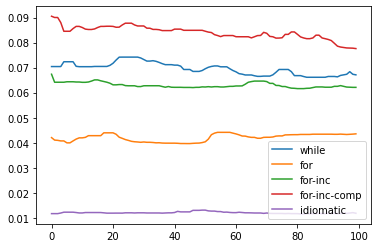

In [59]:
plt.plot(x,r1c, label='while')
plt.plot(x,r2c, label='for')
plt.plot(x,r3c, label='for-inc')
plt.plot(x,r4c, label='for-inc-comp')
plt.plot(x,r5c, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Gráficos de barras

In [60]:
# errores en cada medición
errs = [
    statistics.stdev(t1c, statistics.mean(t1c)),
    statistics.stdev(t2c, statistics.mean(t2c)),
    statistics.stdev(t3c, statistics.mean(t3c)),
    statistics.stdev(t4c, statistics.mean(t4c)),
    statistics.stdev(t5c, statistics.mean(t5c))
]

<BarContainer object of 5 artists>

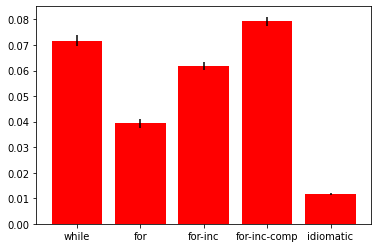

In [61]:
x = ['while','for','for-inc','for-inc-comp','idiomatic']
# promedios
proms = [
    statistics.mean(t1c),
    statistics.mean(t2c),
    statistics.mean(t3c),
    statistics.mean(t4c),
    statistics.mean(t5c)
]
# gráfico de barras
plt.bar(x,proms,color='r',yerr=errs)